# Installs & Imports

In [1]:
!pip install -q linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.iv import IV2SLS

In [3]:
# Set plotting aesthetics
sns.set(style="whitegrid")

# Load the Data

In [4]:
# Generate synthetic data
np.random.seed(42)
n = 1000
z = np.random.normal(size=n)  # Instrument
x = 0.5 * z + np.random.normal(size=n)  # Endogenous variable (correlated with the instrument)
w = np.random.normal(size=n)  # Exogenous variable (additional predictor not correlated with x)
u = np.random.normal(size=n)  # Error term
y = 1.5 * x + 0.5 * w + u  # Outcome variable (dependent variable)

In [5]:
# Create a DataFrame for the data
df = pd.DataFrame({'y': y, 'x': x, 'z': z, 'w': w})

# Display the data
display(df.head())

,y,x,z,w
0,0.226172,1.647713,0.496714,-0.675178
1,0.350608,0.855502,-0.138264,-0.144519
2,-0.234604,0.383475,0.647689,-0.792420
3,1.905574,0.114578,1.523030,-0.307962
4,0.481466,0.581147,-0.234153,-1.893615


# Visualize the Data

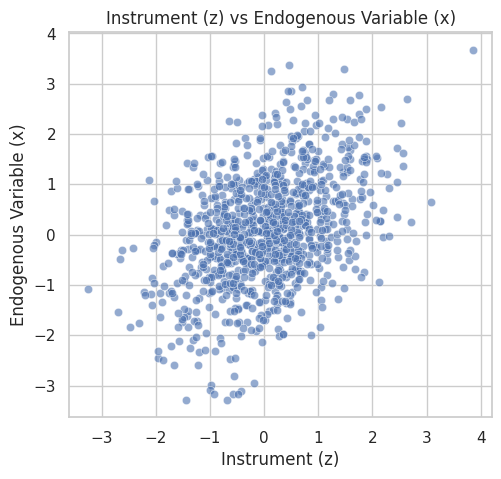

In [6]:
# Visualize the relationship between the instrument (z) and the endogenous variable (x)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df['z'], y=df['x'], alpha=0.6)
plt.title('Instrument (z) vs Endogenous Variable (x)')
plt.xlabel('Instrument (z)')
plt.ylabel('Endogenous Variable (x)');

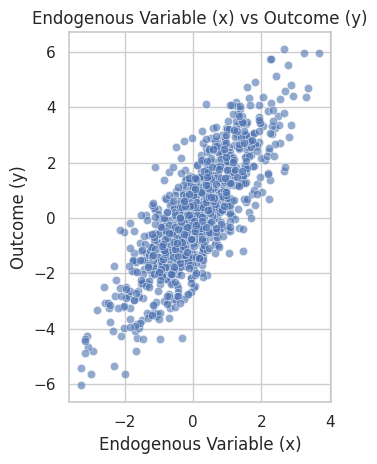

In [7]:
# Visualize the relationship between the endogenous variable (x) and the outcome (y)
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['x'], y=df['y'], alpha=0.6)
plt.title('Endogenous Variable (x) vs Outcome (y)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')

plt.tight_layout()
plt.show()

# IV Regression

In [8]:
# Define the dependent variable (y), the endogenous regressor (x), the instrument (z), and the exogenous variable (w)
y = df['y']
x = df['x']
z = df['z']
w = df['w']

# Add a constant to the DataFrame for the intercept
df['const'] = 1

In [9]:
# First stage regression: x ~ z + w (exclude 'const' from the instruments to avoid collinearity)
first_stage = IV2SLS(df['x'], df[['const', 'w']], None, df[['z']]).fit()

print("First Stage Regression Summary:")
print(first_stage.summary)

First Stage Regression Summary:
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      x   R-squared:                   9.469e-08
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0010
No. Observations:                1000   F-statistic:                    0.0001
Date:                Wed, Sep 11 2024   P-value (F-stat)                0.9918
Time:                        06:51:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0805     0.0345     2.3302     0.0198      0.0128      0.1482
w             -0.000

In [10]:
# Second stage: y ~ x + w | z (IV regression using z as the instrument for x, and including w as an exogenous variable)
iv_model = IV2SLS(df['y'], df[['const', 'w']], df[['x']], df[['z']]).fit()

print("Instrumental Variable (IV) Regression Summary:")
print(iv_model.summary)

Instrumental Variable (IV) Regression Summary:
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.7246
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7241
No. Observations:                1000   F-statistic:                    694.24
Date:                Wed, Sep 11 2024   P-value (F-stat)                0.0000
Time:                        06:51:05   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0163     0.0326    -0.5006     0.6166     -0.0802      0.0475
w    

# Diagnostics & Evaluation

In [11]:
# Checking if the instrument is weak (rule of thumb: F-statistic > 10 indicates strong instrument)
if first_stage.f_statistic:
    print("First Stage F-Statistic (Weak Instrument Test):")
    print(first_stage.f_statistic)

First Stage F-Statistic (Weak Instrument Test):
Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 0.0001
P-value: 0.9918
Distributed: chi2(1)


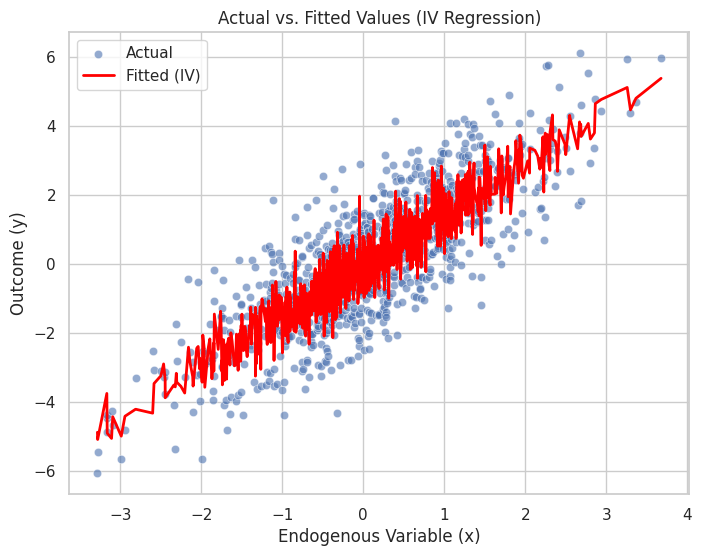

In [12]:
# Predict the fitted values from the IV regression
df['fitted'] = iv_model.fitted_values

# Sort the DataFrame by 'x' values
df_sorted = df.sort_values('x')

# Plot the actual vs. fitted values with sorted data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_sorted['x'], y=df_sorted['y'], label='Actual', alpha=0.6)
plt.plot(df_sorted['x'], df_sorted['fitted'], color='red', label='Fitted (IV)', lw=2)
plt.title('Actual vs. Fitted Values (IV Regression)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')
plt.legend()
plt.show()

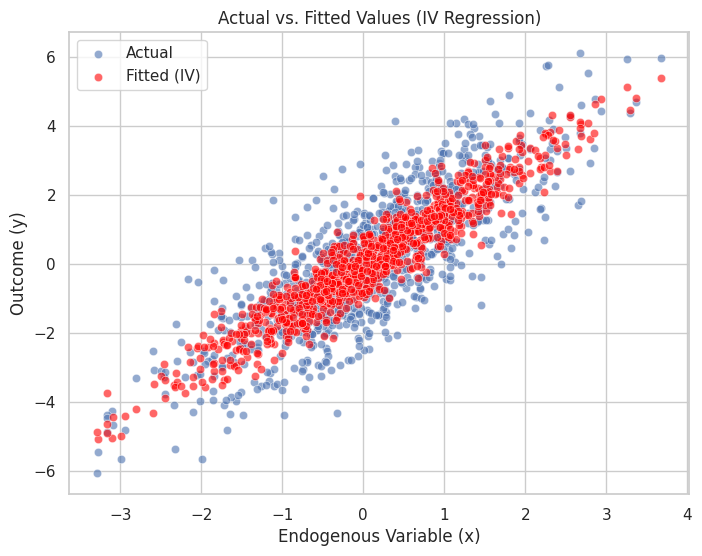

In [13]:
# Plot the actual vs. fitted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['x'], y=df['y'], label='Actual', alpha=0.6)
sns.scatterplot(x=df['x'], y=df['fitted'], color='red', label='Fitted (IV)', alpha=0.6)
plt.title('Actual vs. Fitted Values (IV Regression)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')
plt.legend()
plt.show()

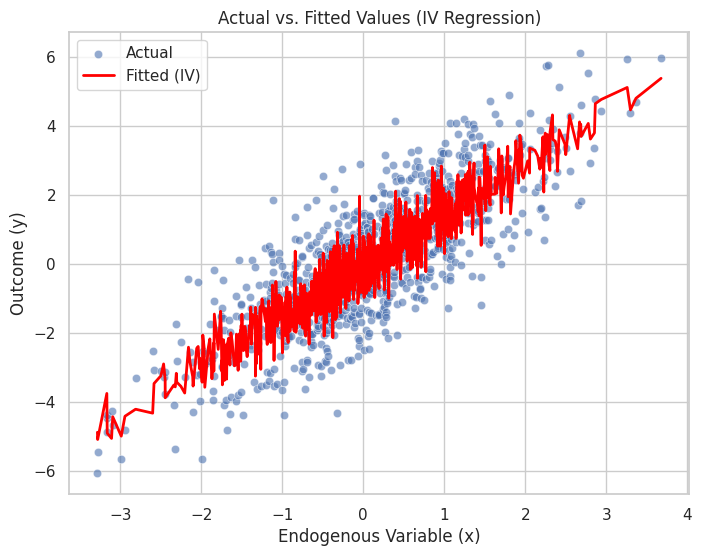

In [14]:
# Sort the DataFrame by 'x' values
df_sorted = df.sort_values('x')

# Plot the actual vs. fitted values with a fitted line (mean line)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_sorted['x'], y=df_sorted['y'], label='Actual', alpha=0.6)
plt.plot(df_sorted['x'], df_sorted['fitted'], color='red', label='Fitted (IV)', lw=2)
plt.title('Actual vs. Fitted Values (IV Regression)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')
plt.legend()
plt.show()

# RPy2 Workflow

In [15]:
!pip install -q rpy2

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import contextlib
import io
import os
from IPython.display import Image, display, HTML
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import r, pandas2ri, DataFrame
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import FloatVector, StrVector
import rpy2.robjects.lib.grdevices as grdevices
import rpy2.ipython.html

# Enable R printing
rpy2.ipython.html.init_printing()

# Enable automatic DataFrame conversion
pandas2ri.activate()

In [17]:
# Function to install and import R packages
def manage_r_packages(packages):
    """
    Installs missing R packages and imports them into Python.

    Parameters:
    packages (list): List of R package names to check, install, and import.

    Returns:
    dict: Dictionary of imported R packages.
    """
    missing_packages = []
    installed_packages = {}

    # Check which packages are already installed and install missing ones
    for package_name in packages:
        try:
            installed_packages[package_name] = importr(package_name)
            print(f"{package_name} is already installed and imported.")
        except PackageNotInstalledError:
            missing_packages.append(package_name)

    # If there are missing packages, install them
    if missing_packages:
        print(f"Installing missing packages: {missing_packages}")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with contextlib.redirect_stdout(None):
                utils.install_packages(StrVector(missing_packages), quiet=True)

        # Import newly installed packages
        for package_name in missing_packages:
            try:
                installed_packages[package_name] = importr(package_name)
                print(f"Successfully installed and imported {package_name}.")
            except Exception as e:
                print(f"Failed to import {package_name} after installation: {str(e)}")
    else:
        print("All required packages are already installed and imported.")

    return installed_packages

In [18]:
# List of required R packages
required_packages = ['AER', 'lazyeval', 'ggplot2', 'stargazer']

# Install and import required R packages
importr('base')
importr('utils')
r_packages = manage_r_packages(required_packages)

ggplot2 is already installed and imported.
Installing missing packages: ['AER', 'lazyeval', 'stargazer']


In [19]:
# Convert Pandas DataFrame into an R DataFrame using ro.DataFrame
r_data = ro.DataFrame(df)

# Add the R DataFrame to the global environment
ro.globalenv['r_data'] = r_data

In [20]:
# Run IV regression and diagnostics in R
ro.r('''
library(AER)

# First stage regression: x ~ z + w (exogenous variable w)
first_stage <- lm(x ~ z + w, data = r_data)
first_stage_summary <- summary(first_stage)

# Second stage IV regression: y ~ x + w | z (exogenous variable w, instrument z)
iv_model <- ivreg(y ~ x + w | z + w, data = r_data)
iv_summary <- summary(iv_model)

# Print summaries of both the first and second stages
print(first_stage_summary)
print(iv_summary)

# Diagnostics: Check for weak instruments
diagnostics <- summary(iv_model, diagnostics = TRUE)
print(diagnostics$diagnostics)
''')


Call:
lm(formula = x ~ z + w, data = r_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.04066 -0.67010 -0.00111  0.64041  3.13370 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.07169    0.03155   2.272   0.0233 *  
z            0.45908    0.03224  14.239   <2e-16 ***
w           -0.01046    0.03210  -0.326   0.7447    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9976 on 997 degrees of freedom
Multiple R-squared:  0.169,	Adjusted R-squared:  0.1673 
F-statistic: 101.4 on 2 and 997 DF,  p-value: < 2.2e-16


Call:
ivreg(formula = y ~ x + w | z + w, data = r_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.92203 -0.73473  0.02452  0.67859  3.25758 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.01631    0.03298  -0.495    0.621    
x            1.46846    0.07227  20.320   <2e-16 ***
w            0.52253    0.03303  15.822   <2e-16

array([[1.00000000e+00, 9.97000000e+02, 2.02761647e+02, 5.09468881e-42],
       [1.00000000e+00, 9.96000000e+02, 1.01019057e-01, 7.50676759e-01],
       [0.00000000e+00,            nan,            nan,            nan]])

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'




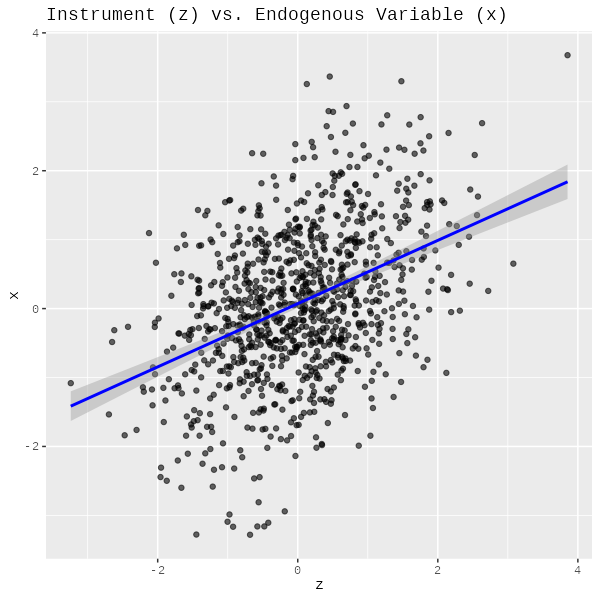

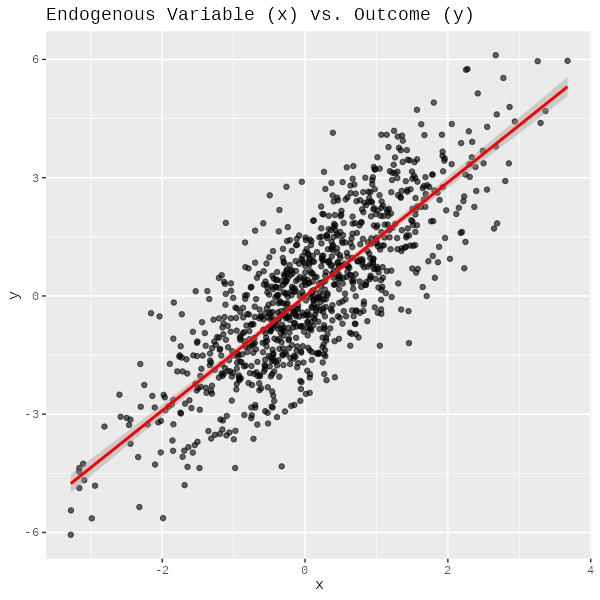

In [21]:
# Ensure the output directory exists
output_dir = "/content/output_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create plots with ggplot2 in R
r_code = '''
library(ggplot2)

# File paths for saving the plots
plot1_path <- "/content/output_plots/instrument_vs_endogenous.png"
plot2_path <- "/content/output_plots/endogenous_vs_outcome.png"

# Plot 1: Instrument (z) vs. Endogenous Variable (x)
p1 <- ggplot(r_data, aes(x=z, y=x)) +
  geom_point(alpha=0.6) +
  geom_smooth(method="lm", col="blue") +
  ggtitle("Instrument (z) vs. Endogenous Variable (x)")

# Save the first plot using ggsave with slightly larger size
ggsave(filename=plot1_path, plot=p1, width=6, height=6, dpi=100)

# Plot 2: Endogenous Variable (x) vs. Outcome (y)
p2 <- ggplot(r_data, aes(x=x, y=y)) +
  geom_point(alpha=0.6) +
  geom_smooth(method="lm", col="red") +
  ggtitle("Endogenous Variable (x) vs. Outcome (y)")

# Save the second plot using ggsave with slightly larger size
ggsave(filename=plot2_path, plot=p2, width=6, height=6, dpi=100)
'''

# Execute the R code to generate and save the plots
ro.r(r_code)

# Display the saved PNG files
print("\n")
display(Image(filename=f"{output_dir}/instrument_vs_endogenous.png"))
display(Image(filename=f"{output_dir}/endogenous_vs_outcome.png"))

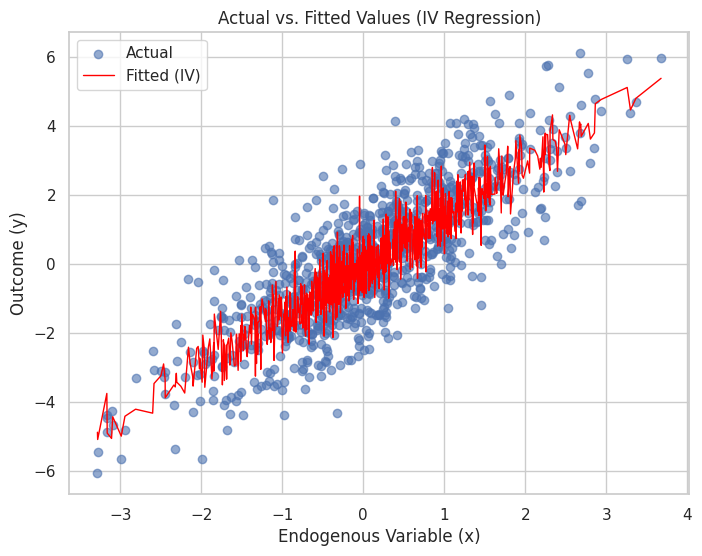

In [22]:
# Extract fitted values from R to Python for plotting
fitted_vals = ro.r('fitted(iv_model)')
df['fitted'] = np.array(fitted_vals)

# Sort the DataFrame by 'x' values
df_sorted = df.sort_values('x')

# Visualize actual vs. fitted Values in Python with sorted values
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted['x'], df_sorted['y'], label='Actual', alpha=0.6)
plt.plot(df_sorted['x'], df_sorted['fitted'], color='red', label='Fitted (IV)', lw=1)
plt.title('Actual vs. Fitted Values (IV Regression)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')
plt.legend()
plt.show()

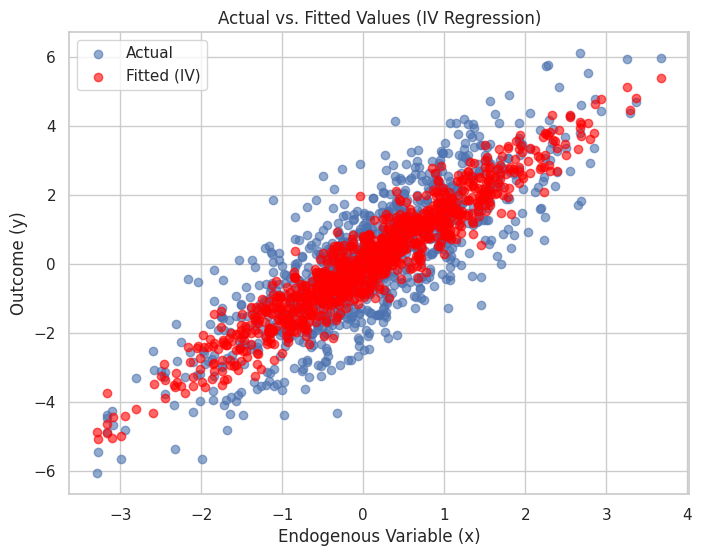

In [23]:
# Visualize actual vs. fitted Values in Python
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], label='Actual', alpha=0.6)
plt.scatter(df['x'], df['fitted'], color='red', label='Fitted (IV)', alpha=0.6)
plt.title('Actual vs. Fitted Values (IV Regression)')
plt.xlabel('Endogenous Variable (x)')
plt.ylabel('Outcome (y)')
plt.legend()
plt.show()

In [24]:
# Print stargazer summary in R
ro.r('''
library(stargazer)

# Generate a formatted summary for the IV regression
stargazer(iv_model,
          type = 'text',
          title = 'Instrumental Variables Regression Summary',
          align = TRUE,                  # Align the columns
          no.space = TRUE,               # Remove extra spaces
          digits = 3,                    # Number of digits after decimal
          covariate.labels = c("Endogenous Var (x)", "Exogenous Var (w)"),  # Custom labels
          dep.var.labels = "Outcome (y)", # Custom dependent variable label
          add.lines = list(c("Instrument used", "z")), # Add a custom line
          notes = "Standard errors in parentheses")
''')


Instrumental Variables Regression Summary
                         Dependent variable:      
                    ------------------------------
                             Outcome (y)          
--------------------------------------------------
Endogenous Var (x)             1.468***           
                               (0.072)            
Exogenous Var (w)              0.523***           
                               (0.033)            
Constant                        -0.016            
                               (0.033)            
--------------------------------------------------
Instrument used                   z               
Observations                    1,000             
R2                              0.725             
Adjusted R2                     0.724             
Residual Std. Error        1.027 (df = 997)       
Note:                  *p<0.1; **p<0.05; ***p<0.01
                    Standard errors in parentheses


,Instrumental Variables Regression Summary,==================================================,Dependent variable:,------------------------------,Outcome (y),--------------------------------------------------,Endogenous Var (x) 1.468***,...,Note: *p<0.1; **p<0.05; ***p<0.01,Standard errors in parentheses
